# Import

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
%tensorflow_version 1.x
import plotly.express as px
from sklearn.svm import SVC
import sklearn.decomposition
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

TensorFlow is already loaded. Please restart the runtime to change versions.


# Functions

In [2]:
class MyPlot():
    def __init__(self,
                 nrows, 
                 ncols, 
                 figsize):
        self.fig, self.axes = plt.subplots(nrows=nrows, 
                                           ncols=ncols, 
                                           figsize=figsize)
        
def my_histogram(ax, data, color, title=None, rwidth=None, log=True, bins=25, align='mid', density=None):
    ax.hist(data, color=color, log=log, bins=bins, edgecolor='black', linewidth=1.2, rwidth=rwidth, align=align, density=density);
    ax.set_title(title);

def plot_random_images(images, examples=16, fig_suptitle=None, figsize=(8,8), fpath=None):

    imgs_index = np.random.choice(np.arange(len(images)), examples, replace=False)

    plot = MyPlot(int(examples/np.sqrt(examples)), int(examples/np.sqrt(examples)), figsize=(8,8))
    plot.axes = plot.axes.ravel()
    image_shape = images[0].shape
    for idx, _ in enumerate(plot.axes):
        X = images[imgs_index[idx]]
        if len(image_shape) == 2:
            plot.axes[idx].imshow(X=X,cmap="gray")
        else:
            plot.axes[idx].imshow(X=X)
        plot.axes[idx].axis('off')
    plot.fig.suptitle(fig_suptitle, fontsize=16)
    if fpath:
        plot.fig.savefig(fpath)        

def compute_confusion_matrix(y_true, y_false):
    cm = confusion_matrix(y_true, y_false)
    return cm


def plot_confusion_matrix(cm,
                          labels_categorical,
                          title=None,
                          normalize=False, 
                          figsize=(8, 8)):
    
    plot = MyPlot(1, 1 ,figsize=figsize)
    ax = plot.axes
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap("Greys"))

    tick_marks = np.arange(len(labels_categorical))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels_categorical, fontsize=16, color="white")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels_categorical, fontsize=16, color="white")

    fmt = '.2f'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if np.isnan(cm[i, j]):
            cm[i, j] = 0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label', fontsize=16, color="white")
    ax.set_xlabel('Predicted label', fontsize=16, color="white")
    ax.xaxis.set_tick_params(rotation=45)

    if title:
        ax.set_title(title)

def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

# Load biological dataset

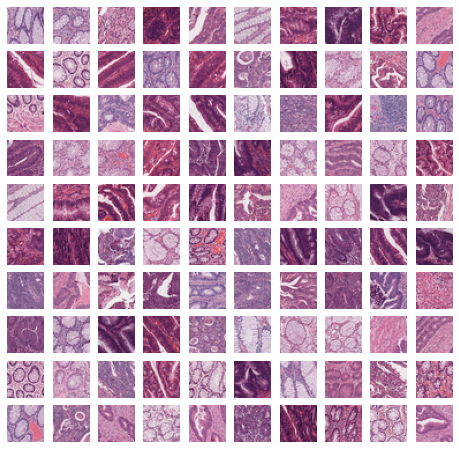

In [3]:
import requests, zipfile, io
#The copied URL goes here ->
r = requests.get("https://github.com/FrPo/crc_3_classi_64x64/blob/master/crc_3_classi.zip?raw=true") 
zip_file = zipfile.ZipFile(io.BytesIO(r.content))
zip_file.extractall()
X_train = np.load("/content/train_X.npy")
Y_train = np.load("/content/train_Y.npy")
X_test = np.load("/content/test_X.npy")
Y_test = np.load("/content/test_Y.npy")
plot_random_images(X_train, 100)

# Preprocess input

In [4]:
mean_image = np.mean(X_train, axis=(0, 1, 2))
X_train_norm = (X_train - mean_image) / 255
X_test_norm = (X_test - mean_image) / 255

# Load pretrained model

In [5]:
IMG_SHAPE = (32, 32, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

# Features extraction

In [6]:
x = base_model.get_layer("block5_pool").output
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D")(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)
layer_features_train = model.predict(X_train_norm)
layer_features_test = model.predict(X_test_norm)

In [7]:
layer_features_train.shape

(9000, 512)

# Features reshape

In [8]:
if len(layer_features_train.shape) > 2:
    # Train
    shape = layer_features_train.shape
    print(shape)
    new_shape = shape[1]*shape[2]*shape[3]
    features_train = np.reshape(layer_features_train, (shape[0], new_shape))
    print(features_train.shape)
    # Test
    shape = layer_features_test.shape
    print(shape)
    new_shape = shape[1]*shape[2]*shape[3]
    features_test = np.reshape(layer_features_test, (shape[0], new_shape))
    print(features_test.shape)

else:
    print("1d array yet")
    features_train = layer_features_train
    features_test = layer_features_test
    print(features_train.shape)

1d array yet
(9000, 512)


# See features with LDA





In [9]:
pca = sklearn.decomposition.PCA(n_components=3).fit(features_train)
features_train_pca = pca.transform(features_train)
features_test_pca = pca.transform(features_test)

In [10]:
features_df = pd.DataFrame(features_train_pca)
fig = px.scatter_3d(features_df, x=0, y=1, z=2, color=Y_train)
fig.show()

# SVM classifier

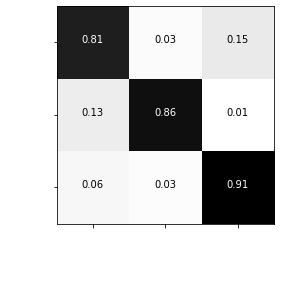

In [11]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(features_train, Y_train)
y_pred = svclassifier.predict(np.squeeze(features_test))
cm = compute_confusion_matrix(Y_test, y_pred)
plot_confusion_matrix(cm, ["AC", "AD", "H"], normalize=True, figsize=(4, 4))

# Fine tuning

In [12]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(len(np.unique(Y_train)), activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:11]:
   layer.trainable = True
for layer in model.layers[11:]:
   layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Training

In [13]:
model.fit(X_train_norm, 
          indices_to_one_hot(Y_train, len(np.unique(Y_train))), 
          batch_size=128, 
          epochs=10,
          validation_split=0.1,
          verbose=1)

Epoch 1/10
64/64 [==============================] - 8s 87ms/step - loss: 0.5769 - accuracy: 0.7400 - val_loss: 0.0862 - val_accuracy: 0.9700
Epoch 2/10
64/64 [==============================] - 4s 59ms/step - loss: 0.0904 - accuracy: 0.9692 - val_loss: 0.0253 - val_accuracy: 0.9933
Epoch 3/10
64/64 [==============================] - 4s 58ms/step - loss: 0.0796 - accuracy: 0.9703 - val_loss: 0.0285 - val_accuracy: 0.9911
Epoch 4/10
64/64 [==============================] - 4s 59ms/step - loss: 0.0551 - accuracy: 0.9802 - val_loss: 0.0352 - val_accuracy: 0.9889
Epoch 5/10
64/64 [==============================] - 4s 59ms/step - loss: 0.0309 - accuracy: 0.9892 - val_loss: 0.0602 - val_accuracy: 0.9789
Epoch 6/10
64/64 [==============================] - 4s 60ms/step - loss: 0.0359 - accuracy: 0.9873 - val_loss: 0.0244 - val_accuracy: 0.9922
Epoch 7/10
64/64 [==============================] - 4s 59ms/step - loss: 0.0180 - accuracy: 0.9920 - val_loss: 0.0017 - val_accuracy: 0.9989
Epoch 8/10
64

# Test

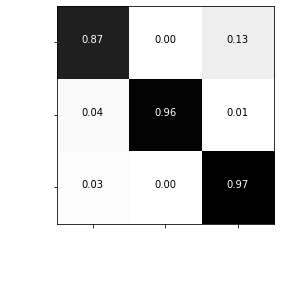

In [14]:
predictions = model.predict(X_test_norm)

cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))
plot_confusion_matrix(cm, ["AC", "AD", "H"], normalize=True, figsize=(4, 4))